Reproducing the Schizophrenia Helicopter experiments. 


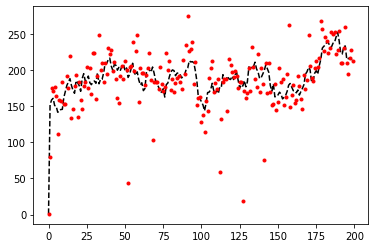

In [2]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt

## Refactor
def get_oddball_trials(numOutcomes=200, sigma = 20, Haz=.125, safe=2, screenWidth=300, drift = 7.5):
    '''# numOutcomes     #how long should the block of trials be?
    # sigma = 20         #standard deviation of the generative dist...
    # Haz=.125           #probability of a change-point on any given trial
    # safe=4;            #except that we set hazard rate equal to zero for "safe" trials after a change-point
    # screenWidth=300
    # drift = 7.5 # '''
    #generate outcomes
    mean=round(rng.uniform()*screenWidth)

    outcome=np.ones((numOutcomes, 1)); #this will be an array of outcomes
    distMean=np.ones((numOutcomes, 1));#this will be an array of distribution mean
    cp=np.zeros((numOutcomes, 1));     #this will be an array of binary change-point variable
    s=safe

    for i in range(1, numOutcomes ):
        if i >1:
            trialDrift=rng.normal(0,drift)

            if  (distMean[i-1]+trialDrift)>0 and (distMean[i-1]+trialDrift)<screenWidth:
                mean= distMean[i-1]+trialDrift
            else:   #If the drift would push you off screen, drift in other direction. 
                mean= distMean[i-1]-trialDrift
        
        if rng.uniform()<Haz and s==0: # Jumpy anywhere.
            outcome[i]=rng.uniform()*screenWidth
            s=safe
        else: #Drift around mean.
            outcome[i]=np.round(rng.normal(mean, sigma))
            counter = 0
            while (outcome[i]>screenWidth) or (outcome[i]<0): # while outcome value not acceptable keep resampling 
                outcome[i]=np.round(rng.normal(mean, sigma))
                counter+=1
                if counter > 5:
                    pass
                    # print('mean: ', mean, ' i: ', i,' outcome[i]: ', outcome[i])
                if counter > 200:
                    print('failed to recover from out of bounds! Breaking')
                    break
            s=max([s-1, 0]) # decrement no of safe trials left.
            
        distMean[i]=mean
    return(distMean,outcome)

distMean, outcome = get_oddball_trials()
plt.plot(distMean, '--k')
plt.plot(outcome, '.r')



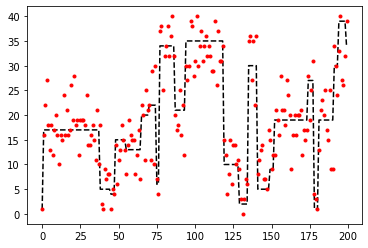

In [3]:
# Shift and update condition
def get_trials(numOutcomes=200, sigma = 20, Haz=.125, safe=2, screenWidth=300):
    '''# numOutcomes     #how long should the block of trials be?
    # sigma = 20         #standard deviation of the generative dist...
    # Haz=.125           #probability of a change-point on any given trial
    # safe=4;            #except that we set hazard rate equal to zero for "safe" trials after a change-point
    # screenWidth=300
    # drift = 7.5 # NO drift in this condition'''
    #generate outcomes
    mean=round(rng.uniform()*screenWidth)

    outcome=np.ones((numOutcomes, 1)); #this will be an array of outcomes
    distMean=np.ones((numOutcomes, 1));#this will be an array of distribution mean
    cp=np.zeros((numOutcomes, 1));     #this will be an array of binary change-point variable
    s=safe

    for i in range(1, numOutcomes ):
        if rng.uniform()<Haz and s==0: # Jumpy anywhere.
            mean= np.round(rng.uniform()*screenWidth)
            cp[i]=1
            s= safe
        else:
            s=max([s-1, 0])
        outcome[i]=np.round(rng.normal(mean, sigma))
        while (outcome[i]>screenWidth) or (outcome[i]<0): # while outcome value not acceptable keep resampling 
            outcome[i]=np.round(rng.normal(mean, sigma))
        s=max([s-1, 0]) # decrement no of safe trials left.
        distMean[i]=mean
    return(distMean,outcome)

distMean, outcome = get_trials(sigma=5, screenWidth=40)
plt.plot(distMean, '--k')
plt.plot(outcome, '.r')



In [16]:
import torch
import torch.nn as nn

batch_size = 100
training_steps = 1000
device = 'cuda:0'
hidden_size = 128
seq_len = 200
screenWidth = 40
input_dim = screenWidth

class RNN_out(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # self.bn = nn.BatchNorm1d(input_size)
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        # inp = self.bn(inp)
        out, hidden = self.gru(inp)
        x = self.linear(out)
        return x, out

def get_batch(type='odd_ball'):
    batches = []
    for i in range(batch_size):
        if type == 'odd_ball':
            _, outcome = get_oddball_trials(seq_len, sigma=3, screenWidth=screenWidth-1, drift=2)
        else:
            _, outcome = get_trials(seq_len, sigma=3, screenWidth=screenWidth-1, drift=2)

        batches.append(outcome)
    batches = np.stack(batches)
    tbatches = torch.nn.functional.one_hot(torch.from_numpy(batches.astype(int)), screenWidth)
    return(tbatches.squeeze().float().to(device))

def test_model():
    # torch.set_grad_enabled(False)
    with torch.no_grad():
        batch = get_batch('odd_ball')
        input = batch[:, :-1, :]
        output = batch[:, -1, :]

        pred, _ = rnn(input.float())
        acc = torch.argmax(pred[:, -1, :], dim = -1) - torch.argmax(output, dim = -1)
        acc = torch.abs(acc) < 4 # consider anthing within 4 steps away as accurate.
        acc = torch.mean(acc.float())
    # torch.set_grad_enabled(True)
    return(acc.detach().cpu().numpy())

rnn = RNN_out(input_size = input_dim, hidden_size=hidden_size, output_size=input_dim).to(device)
opt = torch.optim.Adam(rnn.parameters(), lr= 0.001)
for train_i in range(training_steps):
    batch = get_batch('odd_ball')
    input = batch[:, :-1, :]
    output = batch[:, -1, :]

    pred, _ = rnn(input.float()) # torch.Size([100, 199, 40])
    # loss = nn.functional.nll_loss(pred[:, -1, :],torch.argmax(output, -1))
    # loss = nn.functional.mse_loss(torch.argmax(pred[:, -1, :], -1).float(),torch.argmax(output.float(), -1).float())
    loss = nn.functional.mse_loss(pred[:, -1, :],output)
    opt.zero_grad()
    loss.backward()
    opt.step()

    if train_i % 100 == 0:
        acc = test_model()
        print(f'step: {train_i}  acc: {acc}')




# input would be seq, batch, input_dim
#input from 0 to window_size=300 


step: 0  acc: 0.22999998927116394
step: 100  acc: 0.550000011920929
step: 200  acc: 0.4899999797344208
step: 300  acc: 0.5799999833106995
step: 400  acc: 0.5899999737739563
step: 500  acc: 0.5199999809265137
step: 600  acc: 0.4399999976158142
step: 700  acc: 0.4899999797344208


In [14]:
pred[:,-1,:].shape

False

In [7]:
output.shape

torch.Size([100, 40])

In [45]:
torch.set_grad_enabled(True)

In [49]:
pred.shape

torch.Size([100, 199, 40])

In [19]:
help(torch.nn.functional.one_hot)

Help on built-in function one_hot in module torch._C._nn:

one_hot(...)
    one_hot(tensor, num_classes=-1) -> LongTensor
    
    Takes LongTensor with index values of shape ``(*)`` and returns a tensor
    of shape ``(*, num_classes)`` that have zeros everywhere except where the
    index of last dimension matches the corresponding value of the input tensor,
    in which case it will be 1.
    
    See also `One-hot on Wikipedia`_ .
    
    .. _One-hot on Wikipedia:
        https://en.wikipedia.org/wiki/One-hot
    
    Arguments:
        tensor (LongTensor): class values of any shape.
        num_classes (int):  Total number of classes. If set to -1, the number
            of classes will be inferred as one greater than the largest class
            value in the input tensor.
    
    Returns:
        LongTensor that has one more dimension with 1 values at the
        index of last dimension indicated by the input, and 0 everywhere
        else.
    
    Examples:
        >>> F.one

In [19]:
batches.shape 
tbatches = torch.nn.functional.one_hot(torch.from_numpy(batches.astype(int)), -1)


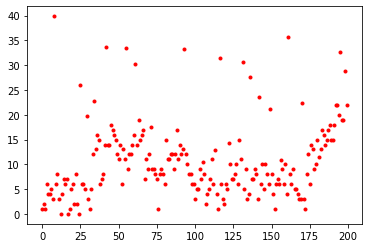

In [20]:

plt.plot(batches[0,:,:], '.r')

In [182]:
batches[0,2,0]

19.0

In [21]:
tbatches[0,2,0]


tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

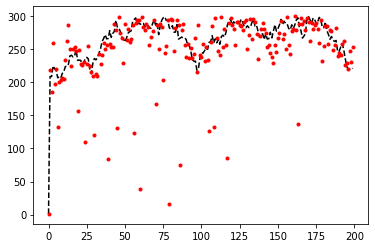

In [2]:

# parameters
#make some outcomes for helicopter task.
#oddballCondition

#pick some
numOutcomes=200    #how long should the block of trials be?
sigma = 20         #standard deviation of the generative dist...
Haz=.125           #probability of a change-point on any given trial
safe=2;            #except that we set hazard rate equal to zero for "safe" trials after a change-point
screenWidth=300
drift = 7.5

#generate outcomes
mean=round(rng.uniform()*screenWidth)

outcome=np.ones((numOutcomes, 1)); #this will be an array of outcomes
distMean=np.ones((numOutcomes, 1));#this will be an array of distribution mean
cp=np.zeros((numOutcomes, 1));     #this will be an array of binary change-point variable
s=safe

for i in range(1, numOutcomes ):
    if i >1:
        trialDrift=rng.normal(0,drift)

        if  (distMean[i-1]+trialDrift)>0 and (distMean[i-1]+trialDrift)<screenWidth:
            mean= distMean[i-1]+trialDrift
        else:   #If the drift would push you off screen, drift in other direction. 
            mean= distMean[i-1]-trialDrift
      
    if rng.uniform()<Haz and s==0: # Jumpy anywhere.
        outcome[i]=rng.uniform()*screenWidth
        s=safe
    else: #Drift around mean.
        outcome[i]=np.round(rng.normal(mean, sigma))
        counter = 0
        while (outcome[i]>screenWidth) or (outcome[i]<0): # while outcome value not acceptable keep resampling 
            outcome[i]=np.round(rng.normal(mean, sigma))
            counter+=1
            if counter > 5:
                print('mean: ', mean, ' i: ', i,' outcome[i]: ', outcome[i])
        
        s=max([s-1, 0]) # decrement no of safe trials left.
        
    distMean[i]=mean

plt.plot(distMean, '--k')
plt.plot(outcome, '.r')


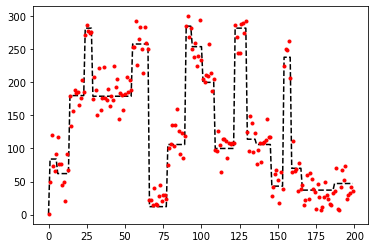

In [8]:

#make some outcomes for helicopter task.
# Shift and update condition

# parameters
numOutcomes=200    #how long should the block of trials be?
sigma = 20         #standard deviation of the generative dist...
Haz=.125           #probability of a change-point on any given trial
safe=4;            #except that we set hazard rate equal to zero for "safe" trials after a change-point
screenWidth=300
# drift = 7.5 # NO drift in this condition

#generate outcomes
mean=round(rng.uniform()*screenWidth)

outcome=np.ones((numOutcomes, 1)); #this will be an array of outcomes
distMean=np.ones((numOutcomes, 1));#this will be an array of distribution mean
cp=np.zeros((numOutcomes, 1));     #this will be an array of binary change-point variable
s=safe

for i in range(1, numOutcomes ):
    if rng.uniform()<Haz and s==0: # Jumpy anywhere.
        mean= np.round(rng.uniform()*screenWidth)
        cp[i]=1
        s= safe
    else:
        s=max([s-1, 0])
    outcome[i]=np.round(rng.normal(mean, sigma))
    while (outcome[i]>screenWidth) or (outcome[i]<0): # while outcome value not acceptable keep resampling 
        outcome[i]=np.round(rng.normal(mean, sigma))
        # for debugging 
        counter+=1
        if counter > 5:
            print('mean: ', mean, ' i: ', i,' outcome[i]: ', outcome[i])       
        s=max([s-1, 0]) # decrement no of safe trials left.
    distMean[i]=mean

plt.plot(distMean, '--k')
plt.plot(outcome, '.r')


In [166]:
max(batches[0,:,0])

40.0

## Gradient experiments to verify possibility of online learning. 

In [1]:
import torch

w = torch.tensor(1.0)
w.requires_grad_(True)

# sub-graph for calculating `x`
x = w+10

# sub-graph for calculating `y1`
x1 = 2*x
y1 = 2*x1
y1.backward(retain_graph=False) # all graph is retained



/om2/user/ahummos/anaconda/lib/python3.8/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


In [129]:
w.grad

tensor(28.)

In [126]:
ys = [torch.tensor(2.) for _ in range(5)]

In [33]:
# y1 = 2*y1
w = torch.tensor(1.0)
w.requires_grad_(True)

y0 = 1.455 * w
y1 = y0 * w
# y1.backward(retain_graph=True) # all graph is retained
y2 = y1 * w
# y2.backward(retain_graph=True) # all graph is retained
# y0 = None
# y1 = None
y3 = y2 * w
y3.backward(retain_graph=False) # all graph is retained


w.grad

tensor(5.8200)

In [37]:
y1.grad_fn = None

AttributeError: attribute 'grad_fn' of 'torch._C._TensorBase' objects is not writable

In [153]:
y2

tensor(1., grad_fn=<MulBackward0>)

In [96]:
w.grad = None

In [80]:
y1 = None
x1 = None

In [22]:
# remove unneeded parts of graph. Note that these parts will be freed from memory (even if they were on GPU), due to python's garbage collection 
# y1 = None
# x1 = None

# sub-graph for calculating `y2`
x2 = torch.sqrt(x)
y2 = x2/2
y2.backward()

In [29]:
import neurogym as ngym

config.tasks

TypeError: append() takes exactly one argument (0 given)

In [31]:
print('task \t\t', 'go_at\t', 'go\t', 'anti\t', 'dec m\t', 'dm1\t','dm2\t', 'ctx\t', 'multi\t', 'match\t', 'nonm\t', 'to_s\t', 'to_c\t', 'delay\t', 'rt\t')
for task in ngym.get_collection('yang19'):
    go_anti = 1 if 'go' in task or 'anti' in task else 0
    go = 1 if 'go' in task else 0
    anti = 1 if 'anti' in task else 0
    decision = 1 if 'dm1' in task or 'dm2' in task or 'dm-' in task else 0
    dm1 = 1 if 'dm1' in task  else 0
    dm2 = 1 if 'dm2' in task  else 0
    match = 1 if 'dms' in task or 'dmc' in task else 0
    non_match = 1 if 'dnms' in task or 'dnmc' in task else 0
    context =  1 if 'ctx' in task  else 0
    multi =  1 if 'multi' in task  else 0
    sample =  1 if 'ms' in task  else 0
    to_cxt =  1 if 'mc' in task  else 0
    delay= 1 if 'dly' in task else 0
    rt = 1 if 'rt' in task else 0
    print(f'{task[7:]:10s}', '\t', go_anti, '\t', go, '\t', anti, '\t', \
        decision, '\t', dm1, '\t', dm2, '\t', context, '\t', multi, '\t',\
            match, '\t', non_match, '\t', sample, '\t', to_cxt, '\t',\
                delay, '\t', rt, '\t')

task 		 go_at	 go	 anti	 dec m	 dm1	 dm2	 ctx	 multi	 match	 nonm	 to_s	 to_c	 delay	 rt	
go-v0      	 1 	 1 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	
rtgo-v0    	 1 	 1 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 1 	
dlygo-v0   	 1 	 1 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 1 	 0 	
anti-v0    	 1 	 0 	 1 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	
rtanti-v0  	 1 	 0 	 1 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 1 	
dlyanti-v0 	 1 	 0 	 1 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 1 	 0 	
dm1-v0     	 0 	 0 	 0 	 1 	 1 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	
dm2-v0     	 0 	 0 	 0 	 1 	 0 	 1 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	
ctxdm1-v0  	 0 	 0 	 0 	 1 	 1 	 0 	 1 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	
ctxdm2-v0  	 0 	 0 	 0 	 1 	 0 	 1 	 1 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	
multidm-v0 	 0 	 0 	 0 	 1 	 0 	 0 	 0 	 1 	 0 	 0 	 0 	 0 	 0 	 0 	
dlydm1-v0  	 0 	 0 	 0 	 1 	 1 	 0 	 0 	 0 	 0 	 0 	 0 	 0 	 1 	 0 	
dlydm2-v0  	 0 	 0 	 0 	 1 	 0 	 1 	 0 	 0 	 0 	 0 	 0 	 0 	 1 	 0 	
ctxdlydm1-v0 

In [ ]:
from configs.refactored_configs import Gates_add_config
config= Gates_add_config()

In [3]:
[(x/10) for x in range(0,10, 2)]
[(x/10) for x in range(1,20, 4)]

[0.1, 0.5, 0.9, 1.3, 1.7]